In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [4]:
# Verify TensorFlow version
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


In [5]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)

856839084/856839084 [==============================] - 131s 0us/step


In [6]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [7]:
# Print the number of images in the train and validation directories
def count_files(dir_path):
    counter = 0
    for root, dirs, files in os.walk(dir_path):
        counter += len(files)
    return counter

In [8]:
print('Total images for training:', count_files(train_dir))
print('Total images for validation:', count_files(validation_dir))

Total images for training: 43444
Total images for validation: 10861


In [9]:
# Define a dictionary with the class indices and names
class_dict = {
    0: 'Apple___Apple_scab',
    1: 'Apple___Black_rot',
    2: 'Apple___Cedar_apple_rust',
    3: 'Apple___healthy',
    4: 'Blueberry___healthy',
    5: 'Cherry_(including_sour)___Powdery_mildew',
    6: 'Cherry_(including_sour)___healthy',
    7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    8: 'Corn_(maize)___Common_rust_',
    9: 'Corn_(maize)___Northern_Leaf_Blight',
    10: 'Corn_(maize)___healthy',
    11: 'Grape___Black_rot',
    12: 'Grape___Esca_(Black_Measles)',
    13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    14: 'Grape___healthy',
    15: 'Orange___Haunglongbing_(Citrus_greening)',
    16: 'Peach___Bacterial_spot',
    17: 'Peach___healthy',
    18: 'Pepper,_bell___Bacterial_spot',
    19: 'Pepper,_bell___healthy',
    20: 'Potato___Early_blight',
    21: 'Potato___Late_blight',
    22: 'Potato___healthy',
    23: 'Raspberry___healthy',
    24: 'Soybean___healthy',
    25: 'Squash___Powdery_mildew',
    26: 'Strawberry___Leaf_scorch',
    27: 'Strawberry___healthy',
    28: 'Tomato___Bacterial_spot',
    29: 'Tomato___Early_blight',
    30: 'Tomato___Late_blight',
    31: 'Tomato___Leaf_Mold',
    32: 'Tomato___Septoria_leaf_spot',
    33: 'Tomato___Spider_mites Two-spotted_spider_mite',
    34: 'Tomato___Target_Spot',
    35: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    36: 'Tomato___Tomato_mosaic_virus',
    37: 'Tomato___healthy'
}

# Create a list of the class names in the correct order
classes = [class_dict[i] for i in range(len(class_dict))]

print('Number of classes:', len(classes))
print(classes)

Number of classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite

In [10]:
# Set up the feature extractor and build the model
module_selection = ("inception_v3", 299, 2048)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/5".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64

Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5 with input size (299, 299) and output dimension 2048


In [11]:
# Set up the data generators
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 10861 images belonging to 38 classes.


In [12]:
do_data_augmentation = True
if do_data_augmentation:
  train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

Found 43444 images belonging to 38 classes.
Metal device set to: Apple M1 Pro


In [14]:
# Set the base_model as the feature extractor's underlying Keras model
base_model = feature_extractor.resolved_object

In [15]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [16]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    Flatten(),
    Dense(512, activation='relu'),
    layers.Dropout(rate=0.2),
    Dense(train_generator.num_classes, activation='softmax',
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                19494     
                                                                 
Total params: 22,871,366
Trainable params: 1,068,582
Non-trainable params: 21,802,784
__________________

In [19]:
# Compile the model
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [20]:
# Train the model
EPOCHS = 5
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1)

Epoch 1/5


2023-05-03 20:26:12.876833: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


679/679 [==============================] - 488s 706ms/step - loss: 0.7659 - accuracy: 0.7773 - val_loss: 0.4064 - val_accuracy: 0.8711
Epoch 2/5
679/679 [==============================] - 476s 701ms/step - loss: 0.3887 - accuracy: 0.8758 - val_loss: 0.3306 - val_accuracy: 0.8943
Epoch 3/5
679/679 [==============================] - 473s 696ms/step - loss: 0.3299 - accuracy: 0.8937 - val_loss: 0.2909 - val_accuracy: 0.9063
Epoch 4/5
679/679 [==============================] - 472s 695ms/step - loss: 0.2992 - accuracy: 0.9030 - val_loss: 0.3270 - val_accuracy: 0.8933
Epoch 5/5
679/679 [==============================] - 472s 695ms/step - loss: 0.2808 - accuracy: 0.9091 - val_loss: 0.2328 - val_accuracy: 0.9260


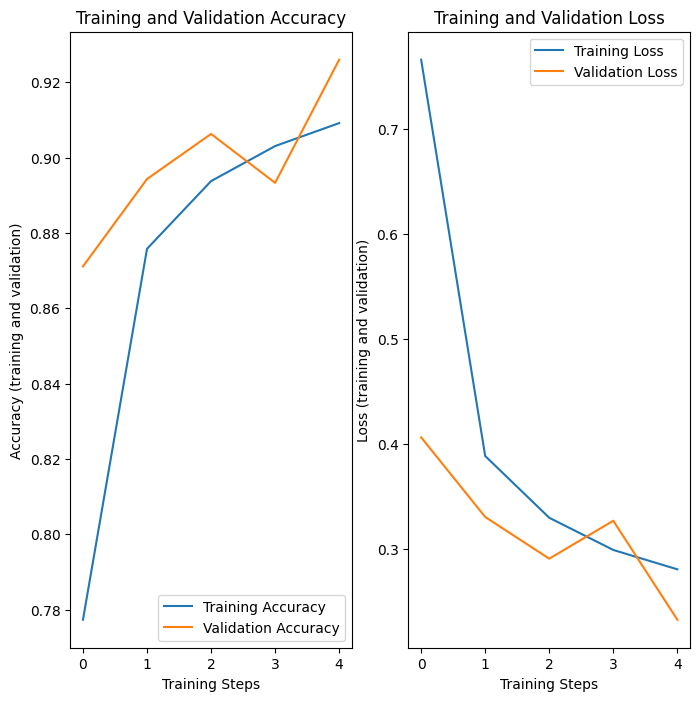

In [21]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [22]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/6eb940fa-5ae3-456f-886a-7c7f4bb7c245___UF.Citrus_HLB_Lab 1132.JPG
1/1 [==============================] - 0s 37ms/step
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.997265


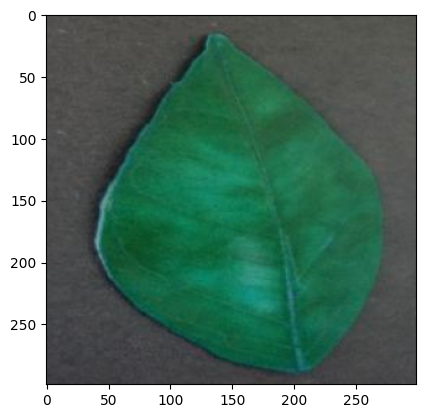

<Figure size 640x480 with 0 Axes>

SOURCE: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), file: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/27864945-3c63-4d6a-9419-e99c14de3486___FAM_L.Blight 3638.JPG
1/1 [==============================] - 0s 29ms/step
PREDICTED: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), confidence: 0.664258


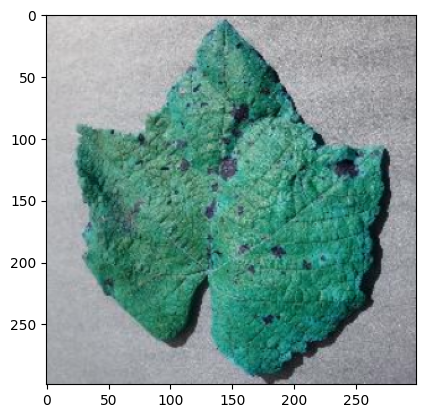

SOURCE: class: Grape___Black_rot, file: Grape___Black_rot/b3a0889f-8c22-4686-992f-81158e7681bc___FAM_B.Rot 0465.JPG
1/1 [==============================] - 0s 30ms/step
PREDICTED: class: Grape___Black_rot, confidence: 0.838780


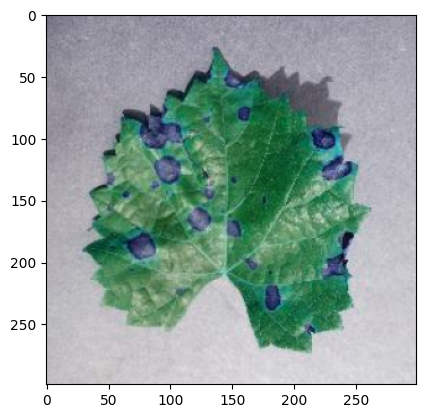

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e154a66-40e6-4215-9200-853b3752635b___YLCV_GCREC 2133.JPG
1/1 [==============================] - 0s 29ms/step
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.993493


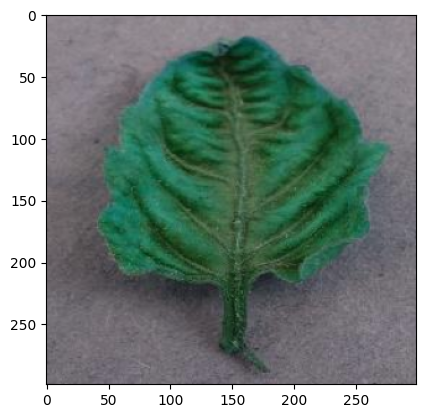

<Figure size 640x480 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/a8d6166c-6057-48cc-9c0d-9cc626d67700___RS_HL 3112.JPG
1/1 [==============================] - 0s 32ms/step
PREDICTED: class: Soybean___healthy, confidence: 0.998250


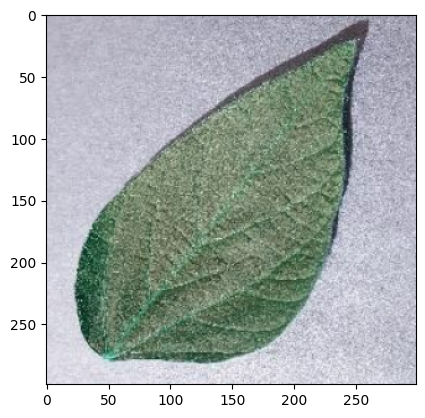

<Figure size 640x480 with 0 Axes>

In [26]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [28]:
import time
t = time.time()

export_path = "~/Desktop/plant/saved_models/{}".format(int(t))
tf.saved_model.save(model, export_path)

export_path

INFO:tensorflow:Assets written to: ~/Desktop/plant/saved_models/1683127618/assets


INFO:tensorflow:Assets written to: ~/Desktop/plant/saved_models/1683127618/assets


'~/Desktop/plant/saved_models/1683127618'

In [30]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

mkdir: tflite_models: File exists


2023-05-03 21:14:11.594992: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-03 21:14:11.595044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


91526544

In [6]:
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    ./saved_model.pb  ./web_model

Traceback (most recent call last):
  File "/Users/rohan/anaconda3/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/Users/rohan/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 827, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/Users/rohan/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 831, in main
    convert(argv[0].split(' '))
  File "/Users/rohan/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 817, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/Users/rohan/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 528, in _dispatch_converter
    tf_saved_model_conversion_v2.convert_tf_saved_model(
  File "/Users/rohan/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/tf_saved_model_conversion_v2.py", line 976, in convert_tf_saved_model
    _conv